In [391]:
import os, glob
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import scipy as scp
import pandas as pd
np.set_printoptions(precision=3)

In [228]:
def reader(filepath):
    all_files = glob.glob(path+'*')[1:-1]
    
    vals_of_interest = ['Material','Weld Type','Width of Specimen and Weld w','Specimen Thickness t','Weld Thickness tw','Specimen Gage Length','Fracture Type and Location','Unwelded Gap Thickness tg (mm)','Maximum Force']
    stop_param = '(s)'
    returnDict = {}
    for file in all_files:
        
        with open(file,'r') as file:
            Dict = {}
                    
            for i in range(30):
                line = file.readline()
                params = line.split(',')
                if params[0] in vals_of_interest:
                    if params[0] != 'Material':
                        try:
                            Dict[params[0]] = float(params[-1].split('\n')[0].split('"')[1])
                        except:
                            Dict[params[0]] = params[-1].split('\n')[0].split('"')[1]
                    if params[0] == 'Material':
                        Dict[params[0]] = params[-1].split('\n')[0].split('"')[1]
                elif params[0] == stop_param:
                    break
            mat = Dict.pop('Material')+  '_'+ Dict.pop('Weld Type')
        
            returnDict[mat] = Dict
            
            data = pd.read_csv(file,header=None)
            _data = data[2]
            where = (np.where(_data <= 1)[0])
            ind_loc = where[min(np.where( where >= 20)[0])]
            
            returnDict[mat]['time'] = np.array(data[0][:ind_loc])
            returnDict[mat]['disp'] = np.array(data[1][:ind_loc])
            returnDict[mat]['force'] = np.array(data[2][:ind_loc])
            returnDict[mat]['strain'] = returnDict[mat]['disp']/Dict['Specimen Gage Length']
            area = Dict['Width of Specimen and Weld w'] * Dict['Specimen Thickness t']
            returnDict[mat]['stress'] = returnDict[mat]['force']/area * 1e3
            
    return returnDict
D = reader(path)
D['q2steel'] = {}
D['q2alum'] = {}
steel = pd.read_csv('data/steel.csv',header=26)
D['q2steel']['strain'] = np.array(steel['(mm/mm)'])
D['q2steel']['stress'] = np.array(steel['(N)']) / (7.1/2)**2 / np.pi
alum = pd.read_csv('data/alum.csv',header=26)
D['q2alum']['strain'] = np.array(alum['(mm/mm)'])[:-1]
D['q2alum']['stress'] = np.array(alum['(N)'])[:-1] / (7.13/2)**2 / np.pi

## Deliv 1

In [229]:
fig,ax = plt.subplot_mosaic([['1018','6061']],figsize = (12,5))
for key in D.keys():
    for plot in ax.keys():
        if plot in key:
            label = key.split('_')[1]
            ax[plot].plot(D[key]['disp'],D[key]['force'],'.',label = label)

for plot in ax.keys():
    ax[plot].grid()
    ax[plot].legend()
    ax[plot].set_ylabel('Load  [kN]')
    ax[plot].set_xlabel('Displacement  [mm]')
fig.savefig('plots/q1-1018-6061.png',dpi = 600)
plt.close()

## Deliv 2

In [273]:
def to_latex(name, arr):
    try:
        returner = [str(np.around(arg,3))+ ' & ' for arg in arr]
    except:
        returner = [arg + ' & ' for arg in arr]
    string = ''.join(returner)
    return name + ' & ' + string[:-3] + ' \\\\'

In [276]:
fig,ax = plt.subplots()
ys = []
uts = []
labels = []
for key in D.keys():
    if 'Chamfer' in key:
        label = key.replace('_',' ')
        x,y = D[key]['strain'],D[key]['stress']
        ax.plot(x,y,label = label)
        if '1018' in key:
            l,u = 5,190
        else:
            l,u = 5,100
        m = scp.stats.linregress(x[l:u],y[l:u]).slope
        b = -m*0.002
        intercept = np.argmin(np.abs(y - (m*x + b)))
        ys.append(y[intercept])
        uts.append(max(y))
        labels.append(label)
ax.legend()
ax.grid()
ax.set_ylabel('Stress  [MPa]')
ax.set_xlabel('Strain  [mm/mm]')
fig.savefig('plots/q2weld.png',dpi = 600)
plt.close()

keys = ['q2steel','q2alum']
labels = ['1018 Steel','6061 Aluminum']
fig,ax = plt.subplots()
for k,l in zip(keys,labels):
    x,y = D[k]['strain'],D[k]['stress']
    ax.plot(x,y,label = l)
    if k == 'q2alum':
        u = 50
    else:
        u = 75
    m = scp.stats.linregress(x[:u],y[:u]).slope
    b = -m*0.002
    intercept = np.argmin(np.abs(y - (m*x + b)))
    ys.append(y[intercept])
    uts.append(max(y))
    labels.append(l)
ax.grid()
ax.legend()
fig.savefig('plots/q2norm.png')
plt.close()
rows = ['Material','Yield Strength','Ultimate Tensile Strength']
vals = [labels,ys,uts]
for r,v in zip(rows,vals):
    print(to_latex(r,v))
    print('\hline')

Material & 1018 Steel & 6061 Aluminum & 1018 Steel & 6061 Aluminum \\
\hline
Yield Strength & 145.204 & 39.908 & 671.854 & 293.534 \\
\hline
Ultimate Tensile Strength & 146.3 & 523.18 & 695.849 & 317.578 \\
\hline


## Deliv 4

1018 Vickers was 230.77143532415633 

6061 Vickers was 29.378363052779825


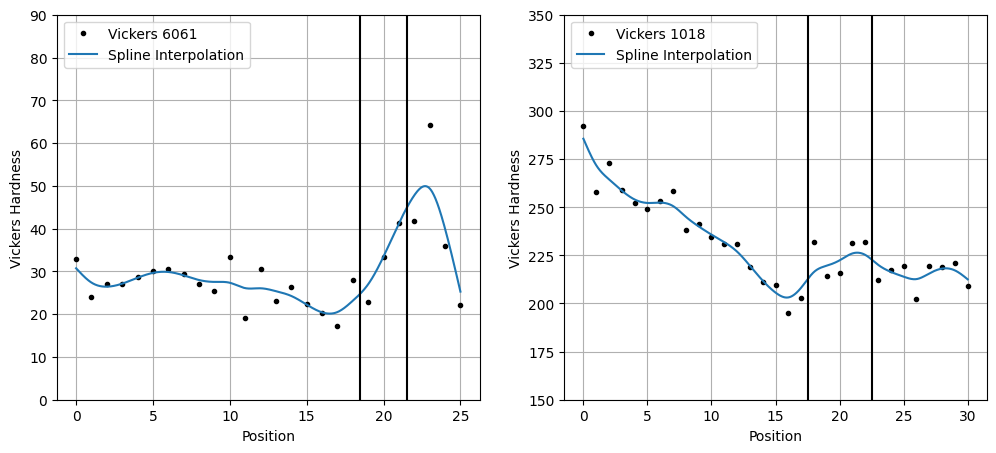

In [379]:
def vickers(arr):
    return 1.85 * .5 / arr**2

v1018 = pd.read_csv('1018v.txt',sep='\t')
diag18 = (np.array(v1018['x-diag']) + np.array(v1018['y-diag']))/2 * 1e-3
pt = np.array(v1018['Number'])
v1018 = vickers(diag18)
f1018 = scp.interpolate.make_smoothing_spline(pt,v1018,lam=.7)


dist = np.linspace(0,25,26)
xdiag = [1.68E+02,1.95E+02,1.81E+02,1.84E+02,1.79E+02,1.75E+02,1.71E+02,1.78E+02,1.85E+02,1.92E+02,1.64E+02,2.19E+02,1.71E+02,2.00E+02,1.86E+02,1.97E+02,2.13E+02,2.36E+02,1.80E+02,1.98E+02,1.65E+02,1.49E+02,1.47E+02,1.21E+02,1.59E+02,2.00E+02]
ydiag = [1.67E+02,1.98E+02,1.89E+02,1.86E+02,1.80E+02,1.76E+02,1.77E+02,1.77E+02,1.85E+02,1.90E+02,1.69E+02,2.21E+02,1.77E+02,2.01E+02,1.88E+02,2.10E+02,2.15E+02,2.28E+02,1.84E+02,2.04E+02,1.68E+02,1.50E+02,1.51E+02,1.19E+02,1.62E+02,2.08E+02]
diag61 = (np.array(xdiag)+np.array(ydiag))/2 * 1e-3
v6061 = vickers(diag61)
f6061 = scp.interpolate.make_smoothing_spline(dist,v6061,lam=.7)

x1 = np.linspace(pt[0],pt[-1],1000)
x6 = np.linspace(dist[0],dist[-1],1000)
fig,ax  = plt.subplot_mosaic([['6061','1018']],figsize = (12,5))
ax['1018'].plot(pt,v1018,'.',color = 'k',label = 'Vickers 1018')
ax['1018'].plot(x1,f1018(x1),label = 'Spline Interpolation')
ax['1018'].axvline(17.5,color = 'k')
ax['1018'].axvline(22.5,color= 'k')
ax['6061'].plot(dist,v6061,'.',color = 'k',label = 'Vickers 6061')
ax['6061'].plot(x6,f6061(x6),label = 'Spline Interpolation')
ax['6061'].axvline(18.5,color = 'k')
ax['6061'].axvline(21.5,color = 'k')
bounds = [(0,90),(150,350)]
for b,key in zip(bounds,ax.keys()):
    ax[key].grid()
    ax[key].legend()
    ax[key].set_ylim(b)
    ax[key].set_xlabel('Position')
    ax[key].set_ylabel('Vickers Hardness')
fig.savefig('plots/q4.png',dpi=600)
#plt.close()
print(f'1018 Vickers was {np.average(v1018)} \n\n6061 Vickers was {np.average(v6061)}')

In [405]:
fig,ax  = plt.subplot_mosaic([['full','fusion'],['full','he'],['full','base']], gridspec_kw={'wspace':-.4})
full = img.imread('plots/1018full.jpg')
fusion = img.imread('plots/1018f.jpg')
he = img.imread('plots/1018he.jpg')
base = img.imread('plots/1018base.jpg')
imgs = [full,fusion,he,base]
for image, plot in zip(imgs,ax.keys()):
    ax[plot].imshow(image)
    ax[plot].axis('off')
fig.tight_layout()
fig.savefig('plots/1018microcollage.png',dpi=1200)
plt.close()

fig,ax  = plt.subplot_mosaic([['full','fusion'],['full','he'],['full','base']], gridspec_kw={'wspace':-.4})
full = img.imread('plots/6061full.jpg')
fusion = img.imread('plots/6061f.jpg')
he = img.imread('plots/6061he.jpg')
base = img.imread('plots/6061base.jpg')
imgs = [full,fusion,he,base]
for image, plot in zip(imgs,ax.keys()):
    ax[plot].imshow(image)
    ax[plot].axis('off')
fig.tight_layout()
fig.savefig('plots/6061microcollage.png',dpi=1200)
plt.close()

/var/folders/d4/pdxfd7q52q5bx7ygq94q2ytc0000gn/T/ipykernel_17716/49172733.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/d4/pdxfd7q52q5bx7ygq94q2ytc0000gn/T/ipykernel_17716/49172733.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [386]:
ax.keys()

dict_keys(['full', 'fusion', 'he', 'base'])

In [312]:
a = 'bcd'
a.replace('bc','')

'd'